# P02: Multi-class SVM Classifier on CIFAR10

In this practical, you will practice putting together a simple classification pipeline. We shall work with the SVM linear classifier. The goals of this practical are as follows:

1. Preprocess the data by **subtracting the mean image**
2. Implement and apply a Multiclass Support Vector Machine (**SVM**) linear classifier
3. Optimize the loss function with **SGD**
4. Perform hyperparameter tuning of the learning rate and regularization strength using **random search**

Once we have completed the task, we shall visualize the weights learnt by gradient descent.

In [1]:
from lib import cifar10
from lib import common
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set the plot
plt.rcParams['image.interpolation'] = 'nearest'

# set to automatic reload
%load_ext autoreload             
%autoreload 2           

# Data preparation

### Loading and preparing the data

First, we load and prepare our data.

In [3]:
# fix unix, dos file path
import os
X_train, y_train, X_test, y_test = cifar10.load_data (os.sep.join(['.','data','cifar-10-batches-py']))
classes = cifar10.get_classes()
num_classes = len(classes)
print('classes:', classes)
print('Shape of training samples:', X_train.shape)
print('Shape of testing samples:',  X_test.shape)

Load ./data/cifar-10-batches-py/data_batch_1
Load ./data/cifar-10-batches-py/data_batch_2
Load ./data/cifar-10-batches-py/data_batch_3
Load ./data/cifar-10-batches-py/data_batch_4
Load ./data/cifar-10-batches-py/data_batch_5
Load ./data/cifar-10-batches-py/test_batch
classes: ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Shape of training samples: (50000, 32, 32, 3)
Shape of testing samples: (10000, 32, 32, 3)


### Get the training, validation, testing and development set

The following code split the data into *train*, *val*, and *test* sets. In addition we will create a small **development set** as a subset of the training data. We shall use this for code development (particularly to develop code to compute the loss function) so our code runs faster.

In [4]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


** Exercise 1: convert the dataset (X_train, X_val, X_test and X_dev) from uint8 to double**

In [5]:
X_train.dtype      # uint8

dtype('uint8')

In [6]:
# Your code here
X_train = X_train.astype('double')
X_val = X_val.astype('double')
X_test = X_test.astype('double')
X_dev = X_dev.astype('double')

In [7]:
X_train.dtype      # expecting float64

dtype('float64')

### Center the data

One of the common step is to **center the data**. This preprocessing step is important if the input is an image which has a range of [0, 255] where all values are positive. When all inputs are positive, this will slow down the training process. More details can be found in the lecture on "Regular Neural Network". 

<img src="imgs\center.png" width="60%">


**Exercise 2: Center all samples**

First,compute the mean image by computing mean of all the images in the training samples. Then, display the mean image.

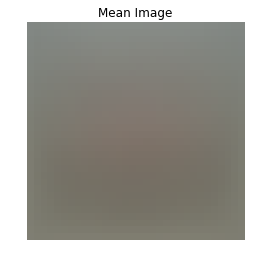

In [8]:
# Your code here
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))
plt.axis('off')
plt.title("Mean Image")
plt.show()

Subtract the mean image from all samples

In [9]:
# your code here
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img
X_dev -= mean_img

**Exercise 3: reshape the image data into rows**

First, reshape the image data [?, 32, 32, 3] into rows [?, 3072] 

In [10]:
# your code here
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_dev = X_dev.reshape(X_dev.shape[0], -1)

In [11]:
# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


### Adding the bias term into W

Lastly we append the bias dimension of ones (i.e. bias trick) so that our SVM only has to worry about optimizing a single weight matrix W.

In [12]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


# Coding the SVM Classifier


** Exercise 4: Develop the function to compute the SVM loss function (non-vectorized version)** 

Now, let's develop the code to build our SVM classifier. Complete the function **`compute_loss_naive`** in **`lib/linear_svm.py`** which implements the multi-svm loss.

<p><center>
$L = \frac{1}{N} \sum_{i} L_i + \lambda R(W)$
</center></p>

<p><center>
$L_i = \sum_{j\neq y_i} max(0, s_j - s_{y_i} + 1) $
</center></p>

where $L$ is the multi-class SVM loss across the whole dataset, $L_i$ is the data loss for sample $i$ and $R(W)$ is the regularizer function, $y_i$ is the true label for sample $i$ and $s_j$ is the score of class $j$ for sample $i$.

For regularization, we shall use the L2 norm.
<p><center>
$R(W) = \sum_j\sum_k W_{j,k}^2$
</center></p>

Complete the function **`compute_loss_naive`** which uses two `for` loops to evaluate the multiclass SVM loss function. Note that the **non-vectorized** implementation is not a very efficient one. We shall develop a more efficient vectorized version later.

In [13]:
from lib.linear_svm import svm_loss_naive

W = np.random.randn(3073, 10) * 0.0000000001 
loss = svm_loss_naive(W, X_dev, y_dev, 0)

print('loss: {:f}'.format(loss))

loss: 9.000000


Note that we have used a very small `W` for the code above.

*Question: Since W is small and the regularization parameter has been turned off, what is the expected value for your SVM loss?* &nbsp;&nbsp;&nbsp;<u>&nbsp;&nbsp;&nbsp;9&nbsp;&nbsp;&nbsp;</u>

Use your answer to check if your implementation above is correct.

### Mini-batch Gradient Descent

You have implemented the loss function. We are now ready to implement mini-batch  gradient descent to find the best parameter $W^*$ that minimizes the loss function $L$.


**Exercise 5: Write the mini-batch gradient descent algorithm**

Now, let's develop the code for the mini-batch gradient descent. Complete the function **`LinearClassifier.train`** in `lib/linear_classifier.py` which implements the gradient descent.

If you completed the task successfully, you should see that the loss decreases from around 780 to 5.5 over the iterations.

In [14]:
from lib.linear_classifier import LinearSVM
import time

tic = time.time()

svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, 
                      batch_size=200, 
                      learning_rate=1e-7, 
                      reg=2.5e4, 
                      num_epochs=5, 
                      vectorized = True, 
                      verbose=True)

toc = time.time()
print('That took %fs' % (toc - tic))

epoch 0 / 5, iteration 0 / 244: loss 790.603938
epoch 0 / 5, iteration 100 / 244: loss 289.131918
epoch 0 / 5, iteration 200 / 244: loss 108.013912
epoch 0 / 5, iteration 244 / 244: loss 71.545688
epoch 1 / 5, iteration 0 / 244: loss 70.746487
epoch 1 / 5, iteration 100 / 244: loss 29.433455
epoch 1 / 5, iteration 200 / 244: loss 13.732655
epoch 1 / 5, iteration 244 / 244: loss 11.111898
epoch 2 / 5, iteration 0 / 244: loss 10.983970
epoch 2 / 5, iteration 100 / 244: loss 7.556812
epoch 2 / 5, iteration 200 / 244: loss 5.814544
epoch 2 / 5, iteration 244 / 244: loss 6.026459
epoch 3 / 5, iteration 0 / 244: loss 5.954920
epoch 3 / 5, iteration 100 / 244: loss 5.684876
epoch 3 / 5, iteration 200 / 244: loss 5.149529
epoch 3 / 5, iteration 244 / 244: loss 5.593204
epoch 4 / 5, iteration 0 / 244: loss 5.528325
epoch 4 / 5, iteration 100 / 244: loss 5.520210
epoch 4 / 5, iteration 200 / 244: loss 5.095535
epoch 4 / 5, iteration 244 / 244: loss 5.557141
Total number of iterations: 1225
That 

A useful debugging strategy is to plot the loss as a function of iteration number. The following code plots the graph loss vs iteration. The loss should decrease over time. 

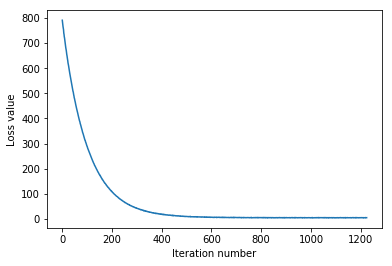

In [15]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

**Exercise 6: Write the prediction function**

Now, let's develop the code to predict the labels for any samples. Complete the function **`LinearClassifier.train`** in `lib/linear_classifier.py` and then evaluate the performance on training and validation set.

If you completed the task successfully, We are expecting an accuracy of about 3.6 or above for the model we created above.

In [16]:
y_train_pred = svm.predict(X_train)
print('Training accuracy: {:f}'.format(np.mean(y_train == y_train_pred)))

y_val_pred = svm.predict(X_val)
print('validation accuracy: {:f}'.format(np.mean(y_val == y_val_pred)))

Training accuracy: 0.364327
validation accuracy: 0.373000


# Training and hyperparameter tuning

Now that we have developed all the necessary code, it's time to perform training. We shall use the validation set to finetune hyperparameters (regularization strength and learning rate). 

**Exercise 7: Write the cross-validation code (Random Search) for hyperparameter tuning**

Write the code that chooses the best hyperparameters by tuning on the validation set. 

In the previous practical, we have used **Grid Search** for cross-validation. Today, we are going to use **Random Search** to determine our best hyperprameter on the validation set. Random search has been shown to produce comparable performance with lots of computational saving. Complete the code below to find the best hyperparameter settings.

*Hint*: You should use a small value for the number of batch iterations (`max_iter = 100`) as you develop your validation code so that the SVMs don't take much time to train. Once you are confident that your validation code works, you should rerun the validation code with a larger number of iterations (`max_iter = -1`).                                      

In [17]:
results = {}               # results is dictionary mapping (learning_rate, regularization_strength) 
                           # to (training_accuracy, validation_accuracy). The accuracy is simply the 
                           #fraction of data points that are correctly classified.
best_val = -1              # The highest validation accuracy that we have seen so far.
best_svm = None            # The LinearSVM object that achieved the highest validation rate.

# hyperparameter settings
learning_rates = [-6, -3]            
regularization_strengths = [-4, 0]
num_trials = 25

for i in range(num_trials): 
    
    ################################################################################
    # TODO:                                                                        #
    # sample the learning rate and regularization hyperparameters in log space     #
    ################################################################################
    
    lr  = 10**np.random.uniform(learning_rates[0], learning_rates[1])
    reg = 10**np.random.uniform(regularization_strengths[0], regularization_strengths[1])
    
    ################################################################################
    #                       END OF YOUR CODE                                       #
    ################################################################################
    
    ################################################################################
    # TODO:                                                                        #
    # Train on the training set. Set number of epochs to 7, maximum number of      #
    #     iteration to 100, verbose to False. Set to use the vectorized version if #
    #     possible.                                                                # 
    ################################################################################
    
    svm = LinearSVM()
    loss = svm.train(X_train, y_train, learning_rate=lr, reg=reg, 
                         num_epochs=7, max_iter=100, vectorized=True, verbose=False)

    ################################################################################
    #                       END OF YOUR CODE                                       #
    ################################################################################
        
    ################################################################################
    # TODO:                                                                        #
    # Evaluate your model on both the training and validation set                  #
    ################################################################################
    
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)

    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    
    ################################################################################
    #                       END OF YOUR CODE                                       #
    ################################################################################
        
    results[(lr, reg)] = (train_accuracy, val_accuracy)
        
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm
        
    print('iter {:d}: lr {:e} reg {:e} train accuracy: {:.4f} val accuracy: {:.4f}'.format(
                i, lr, reg, train_accuracy, val_accuracy))
    

# Sort the validation result for easy viewing
import operator
sorted_results = sorted(results.items(), key=operator.itemgetter(1))
print('\n---------------------------------- Sorted result ----------------------------------')
for ((lr, reg), (train_acc, val_acc)) in sorted_results:
    print('lr {:e}, reg{:e}: train accuracy: {:.4f} val accuracy: {:.4f}'.format(lr, reg, train_acc, val_acc))
print('>> Best validation: {:.4f}'.format(best_val))

iter 0: lr 1.940262e-06 reg 1.585062e-01 train accuracy: 0.3131 val accuracy: 0.3180
iter 1: lr 8.385001e-04 reg 5.738768e-01 train accuracy: 0.3299 val accuracy: 0.3410
iter 2: lr 2.525417e-04 reg 7.020417e-04 train accuracy: 0.3316 val accuracy: 0.3370
iter 3: lr 2.599803e-04 reg 1.416497e-04 train accuracy: 0.3317 val accuracy: 0.3400
iter 4: lr 1.837300e-04 reg 1.129295e-04 train accuracy: 0.3317 val accuracy: 0.3320
iter 5: lr 1.907126e-05 reg 3.245396e-03 train accuracy: 0.3300 val accuracy: 0.3380
iter 6: lr 1.908737e-06 reg 2.579640e-04 train accuracy: 0.3172 val accuracy: 0.3090
iter 7: lr 1.657146e-04 reg 5.112262e-01 train accuracy: 0.3323 val accuracy: 0.3450
iter 8: lr 4.640682e-05 reg 1.321673e-01 train accuracy: 0.3349 val accuracy: 0.3340
iter 9: lr 3.433723e-06 reg 1.243293e-01 train accuracy: 0.3217 val accuracy: 0.3120
iter 10: lr 1.241795e-05 reg 3.841785e-04 train accuracy: 0.3348 val accuracy: 0.3370
iter 11: lr 2.069462e-04 reg 1.497508e-03 train accuracy: 0.3335

**Exercise 8: Optimize your hyperparameters on the validation set** 

Hyperparameter tuning is performed in stages. The first stage is to find the range of working range for hyperparameters (we have done this for you). Then, yYou should repeat the above process using a finer ranges for the learning rate and regularization strength. You may repeat this several times until you are satisfied with the performance of your system on the validation set. If you are careful you should be able to get a classification accuracy of about 0.4 on the validation set. 

*What is the best accuracy that you can achieve? What is the finest range of learning rates and regularization strength that you evaluate on?*
<br> **Answer**: \_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_

# Evaluation and Analysis

### Evaluating on the testing set

**Exercise 9: Evaluate on the test set**

From above, we determine the best hyperparameter settings through cross-validation. The best model has also been saved as `best_svm`. The following code shows the prediction resut on the test set

In [18]:
# your code here
y_test_pred = best_svm.predict(X_test)
print('testing accuracy: {:f}'.format(np.mean(y_test == y_test_pred)))

testing accuracy: 0.307000


### Visualizing the template

Now, let's visualize the learnt weights for each class. Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

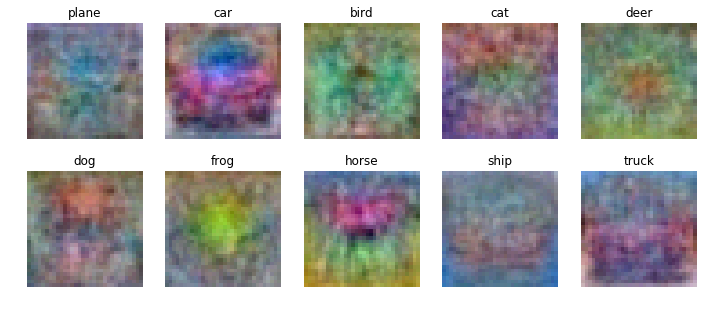

In [19]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)

    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

---
# Course Assignment 2 [2 marks]

** Submission**:

This is the second coursework assignment which extends this practical. Complete this section and upload the following file to WBLE by 11 Feb 2018. 
* `linear_svm.py`


**Task: Vectorized version of the multi-class SVM loss**.

For this assignment, your task is to implement the vectorized version of the multiclass svm loss function. Complete the function **`svm_loss_vectorized`** in `linear_svm.py`. The function should NOT contain any for loops. 

After you have completed your assignment, verify your implementation by running the code below. The loss computed by the vectorized version must be equal to the naive version. The vectorized version should be much more efficient than the non-vectorized version.

In [20]:
from lib.linear_svm import svm_loss_naive
from lib.linear_svm import svm_loss_vectorized

tic = time.time()

W = np.random.randn(3073, 10) * 0.0000000001 
loss_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: {:.2f}'.format(loss_naive - loss_vectorized))

Naive loss: 9.000000e+00 computed in 0.046040s
Vectorized loss: 9.000000e+00 computed in 0.006146s
difference: -0.00
